In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/100-bird-species/birds'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter('ignore')

import cv2
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,Lambda,Flatten,Dropout
from tensorflow.keras.layers import Input,MaxPooling2D,BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten,BatchNormalization,Activation,Input

from keras.applications import resnet50
from keras.applications.resnet50 import preprocess_input
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import (ImageDataGenerator, 
                                       img_to_array, 
                                       array_to_img, 
                                       load_img)

In [3]:
train = '../input/100-bird-species/birds/train'
test = '../input/100-bird-species/birds/test'
val = '../input/100-bird-species/birds/valid'
df = pd.read_csv("../input/100-bird-species/birds/birds.csv")

In [4]:
df.head()

,Unnamed: 0,filepaths,labels,data set
0,0,train\AFRICAN CROWNED CRANE\001.jpg,AFRICAN CROWNED CRANE,train
1,1,train\AFRICAN CROWNED CRANE\002.jpg,AFRICAN CROWNED CRANE,train
2,2,train\AFRICAN CROWNED CRANE\003.jpg,AFRICAN CROWNED CRANE,train
3,3,train\AFRICAN CROWNED CRANE\004.jpg,AFRICAN CROWNED CRANE,train
4,4,train\AFRICAN CROWNED CRANE\005.jpg,AFRICAN CROWNED CRANE,train


In [5]:
df = df.sample(frac=1)
df_for_img = df.head()
df_for_img

,Unnamed: 0,filepaths,labels,data set
35446,35446,train\TIT MOUSE\081.jpg,TIT MOUSE,train
12044,12044,train\DOUBLE BARRED FINCH\018.jpg,DOUBLE BARRED FINCH,train
2513,2513,train\BALD EAGLE\104.jpg,BALD EAGLE,train
38061,38061,train\WHITE NECKED RAVEN\061.jpg,WHITE NECKED RAVEN,train
30080,30080,train\RED WISKERED BULBUL\016.jpg,RED WISKERED BULBUL,train


In [7]:
paths = []
for i in range(5):
    x = df_for_img.iloc[i][1].split('\\')
    y = '/'.join(x)
    paths.append(y)
df_path = pd.DataFrame(paths)
df_path.columns=['paths']
df_path

,paths
0,train/TIT MOUSE/081.jpg
1,train/DOUBLE BARRED FINCH/018.jpg
2,train/BALD EAGLE/104.jpg
3,train/WHITE NECKED RAVEN/061.jpg
4,train/RED WISKERED BULBUL/016.jpg


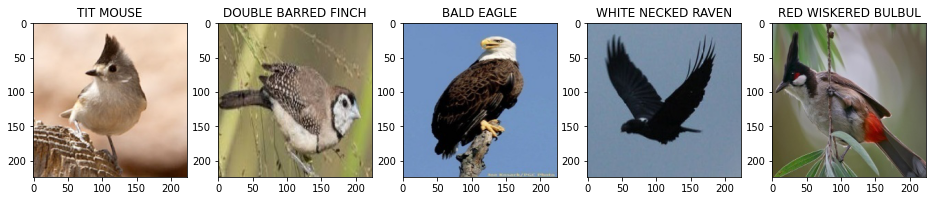

In [17]:
plt.figure(figsize=(16,11))
folder = '../input/100-bird-species/285 birds/'    
for i in range(5):
    plt.subplot(1,5,i+1)
    x = folder + df_path.iloc[i][0]
    image = plt.imread(x)
    plt.imshow(image)
    plt.title(df_for_img.iloc[i][2])

In [18]:
size  = 224
batch_size = 256
train_datagen = ImageDataGenerator(
                             #rotation_range=10,
                             #zoom_range=0.1,
                             #horizontal_flip=True,
                             #fill_mode='nearest',
                             #width_shift_range=0.1,
                             #height_shift_range=0.1,
                             #preprocessing_function = preprocess_input,
                             rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train,  
        target_size=(size, size), 
        batch_size=batch_size,
        class_mode='sparse')

Found 39364 images belonging to 275 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1/255)
    #preprocessing_function = preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
        val,  
        target_size=(size, size), 
        #color_mode='rgb',
        batch_size=batch_size,
        class_mode='sparse')

Found 1375 images belonging to 275 classes.


In [20]:
test_datagen = ImageDataGenerator(rescale=1/255)
    #preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(
        test,  
        target_size=(size, size),  
        batch_size=batch_size,
        #color_mode='rgb',
        class_mode='sparse',
        shuffle=False)

Found 1375 images belonging to 275 classes.


In [21]:
from keras.applications import ResNet101V2
convlayer=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

171319296/171317808 [==============================] - 5s 0us/step


In [22]:
folder = len(os.listdir(train))
folder

275

In [23]:
model=Sequential()
model.add(convlayer)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(275,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [24]:
opt=tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

In [25]:
history=model.fit(train_generator,validation_data=validation_generator,
         epochs=5)

Epoch 1/5
154/154 [==============================] - 466s 3s/step - loss: 3.4842 - accuracy: 0.3354 - val_loss: 0.3435 - val_accuracy: 0.9076
Epoch 2/5
154/154 [==============================] - 177s 1s/step - loss: 0.4738 - accuracy: 0.8911 - val_loss: 0.2202 - val_accuracy: 0.9396
Epoch 3/5
154/154 [==============================] - 165s 1s/step - loss: 0.1726 - accuracy: 0.9633 - val_loss: 0.1877 - val_accuracy: 0.9469
Epoch 4/5
154/154 [==============================] - 170s 1s/step - loss: 0.0839 - accuracy: 0.9841 - val_loss: 0.1733 - val_accuracy: 0.9542
Epoch 5/5
154/154 [==============================] - 187s 1s/step - loss: 0.0547 - accuracy: 0.9888 - val_loss: 0.1602 - val_accuracy: 0.9513


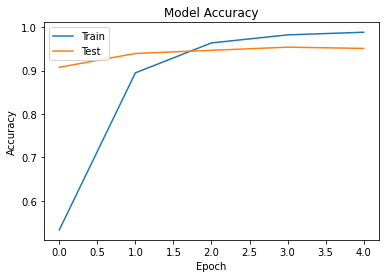

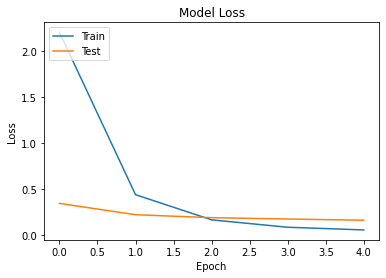

In [26]:
#Training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='upper left')
plt.show()
#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='upper left')
plt.show()

# Model Saving

In [27]:
model.save("./saved_model/")

In [28]:
model.save("birds_classification_resnet101v2.h5")
loaded_model = load_model('birds_classification_resnet101v2.h5', compile = False)

## Quantization

## Without quantization

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

In [30]:
len(tflite_model)

1002527588

## with quantization

In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [32]:
len(tflite_quant_model)

252707104

In [33]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [34]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

## Testing

In [35]:
labels = train_generator.class_indices
labels_reverse = {k:v for v,k in labels.items()}
labels_reverse

{0: 'AFRICAN CROWNED CRANE',
 1: 'AFRICAN FIREFINCH',
 2: 'ALBATROSS',
 3: 'ALEXANDRINE PARAKEET',
 4: 'AMERICAN AVOCET',
 5: 'AMERICAN BITTERN',
 6: 'AMERICAN COOT',
 7: 'AMERICAN GOLDFINCH',
 8: 'AMERICAN KESTREL',
 9: 'AMERICAN PIPIT',
 10: 'AMERICAN REDSTART',
 11: 'ANHINGA',
 12: 'ANNAS HUMMINGBIRD',
 13: 'ANTBIRD',
 14: 'ARARIPE MANAKIN',
 15: 'ASIAN CRESTED IBIS',
 16: 'BALD EAGLE',
 17: 'BALI STARLING',
 18: 'BALTIMORE ORIOLE',
 19: 'BANANAQUIT',
 20: 'BANDED BROADBILL',
 21: 'BAR-TAILED GODWIT',
 22: 'BARN OWL',
 23: 'BARN SWALLOW',
 24: 'BARRED PUFFBIRD',
 25: 'BAY-BREASTED WARBLER',
 26: 'BEARDED BARBET',
 27: 'BEARDED REEDLING',
 28: 'BELTED KINGFISHER',
 29: 'BIRD OF PARADISE',
 30: 'BLACK & YELLOW bROADBILL',
 31: 'BLACK FRANCOLIN',
 32: 'BLACK SKIMMER',
 33: 'BLACK SWAN',
 34: 'BLACK TAIL CRAKE',
 35: 'BLACK THROATED BUSHTIT',
 36: 'BLACK THROATED WARBLER',
 37: 'BLACK VULTURE',
 38: 'BLACK-CAPPED CHICKADEE',
 39: 'BLACK-NECKED GREBE',
 40: 'BLACK-THROATED SPARROW',
 41:

In [36]:
def output(location):
    img = load_img(location, target_size = (224, 224, 3))
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, [0])
    answer = loaded_model.predict(img)
    y_class = answer.argmax(axis = -1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels_reverse[y]
    return res

'AMERICAN KESTREL'

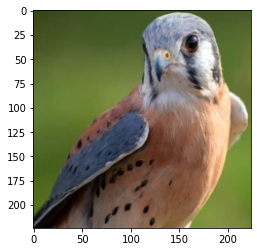

In [37]:
img = '../input/100-bird-species/birds/test/AMERICAN KESTREL/3.jpg'
pic = load_img(img, target_size = (224, 224, 3))
plt.imshow(pic)
output(img)

'BAY-BREASTED WARBLER'

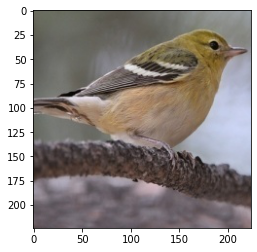

In [38]:
img = '../input/100-bird-species/birds/test/BAY-BREASTED WARBLER/2.jpg'
pic = load_img(img, target_size = (224, 224, 3))
plt.imshow(pic)
output(img)

'AMERICAN COOT'

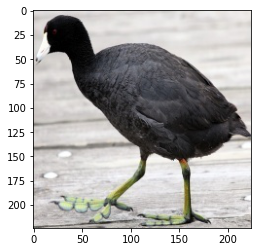

In [39]:
img = '../input/100-bird-species/birds/valid/AMERICAN COOT/1.jpg'
pic = load_img(img, target_size = (224, 224, 3))
plt.imshow(pic)
output(img)

# Test Accuracy

In [40]:
model.evaluate(test_generator)

6/6 [==============================] - 14s 3s/step - loss: 0.1295 - accuracy: 0.9600


[0.12946732342243195, 0.9599999785423279]